In [ ]:
# 1. Adım: Gerekli kütüphaneleri import etme
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [ ]:
# 2. Adım: Veri setini yükleme
uploaded = files.upload()  # Veri setini yükle (örneğin powerconsumption.csv)
df = pd.read_csv(list(uploaded.keys())[0])


Saving powerconsumption.csv to powerconsumption.csv


In [ ]:
# 3. Adım: Veri Ön İşleme
# 3.1. Datetime'ı datetime formatına çevirme ve saatlik ortalamalara dönüştürme
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
df_hourly = df.resample('h').mean()  # Saatlik ortalama al ('H' yerine 'h' kullanıldı)
df_hourly.reset_index(inplace=True)

# 3.2. Normalizasyon
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
            'DiffuseFlows', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2',
            'PowerConsumption_Zone3']
scaler = MinMaxScaler()
df_hourly[features] = scaler.fit_transform(df_hourly[features])

# 3.3. Zaman penceresi oluşturma (12 saatlik geçmiş)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])  # Geçmiş 12 saat
        y.append(data[i + seq_length, -3:])  # Son 3 sütun (Zone 1, 2, 3)
    return np.array(X), np.array(y)

data = df_hourly[features].values
seq_length = 12  # 12 saatlik geçmiş
X, y = create_sequences(data, seq_length)

# Şekilleri kontrol etme
print("X şekli:", X.shape)
print("y şekli:", y.shape)


X şekli: (8724, 12, 8)
y şekli: (8724, 3)


In [ ]:
# 3.4. Eğitim, doğrulama ve test setlerine ayırma
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

print("\nEğitim seti X şekli:", X_train.shape)
print("Eğitim seti y şekli:", y_train.shape)
print("Doğrulama seti X şekli:", X_val.shape)
print("Doğrulama seti y şekli:", y_val.shape)
print("Test seti X şekli:", X_test.shape)
print("Test seti y şekli:", y_test.shape)



Eğitim seti X şekli: (6106, 12, 8)
Eğitim seti y şekli: (6106, 3)
Doğrulama seti X şekli: (1308, 12, 8)
Doğrulama seti y şekli: (1308, 3)
Test seti X şekli: (1310, 12, 8)
Test seti y şekli: (1310, 3)


In [ ]:
# 4. Adım: LSTM Modelini Kurma ve Eğitme
# 4.1. Modeli oluşturma
model = Sequential([
    LSTM(128, input_shape=(12, 8), return_sequences=True),  # İlk LSTM katmanı, 128 nöron
    Dropout(0.1),  # Dropout %10
    LSTM(64),  # İkinci LSTM katmanı, 64 nöron
    Dropout(0.1),
    Dense(32, activation='relu'),  # Ara katman
    Dense(3, activation='linear')  # Çıkış katmanı (Zone 1, 2, 3)
])

# Model özetini yazdırma
print("\nModel Özeti:")
model.summary()

# 4.2. Modeli derleme
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 4.3. Callbacks tanımlama
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Model Özeti:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 12, 128)             │          70,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,731 (475.51 KB)

 Trainable params: 121,731 (475.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 4.4. Modeli eğitme
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)


Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0330 - mae: 0.1345 - val_loss: 0.0139 - val_mae: 0.0971 - learning_rate: 0.0010
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0081 - mae: 0.0698 - val_loss: 0.0091 - val_mae: 0.0767 - learning_rate: 0.0010
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0052 - mae: 0.0560 - val_loss: 0.0069 - val_mae: 0.0651 - learning_rate: 0.0010
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0045 - mae: 0.0516 - val_loss: 0.0045 - val_mae: 0.0508 - learning_rate: 0.0010
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0036 - mae: 0.0459 - val_loss: 0.0040 - val_mae: 0.0467 - learning_rate: 0.0010
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0032 - mae: 0.0432 - val_loss: 0.0034 - val_mae: 0.0434 - learning_rate: 0.0010
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0029 - mae: 0.0409 - val_loss: 0.0032 - val_mae: 0.0443 - learning_rate: 0.0010
Epoc

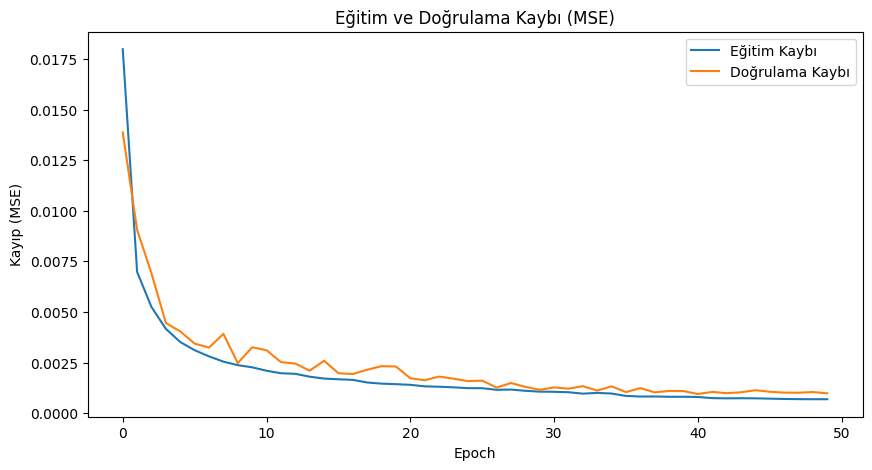

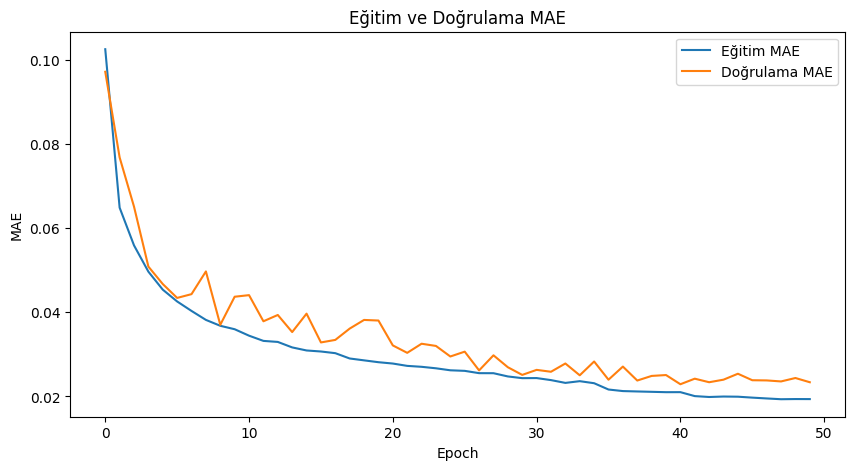

In [ ]:
# 4.5. Eğitim sürecini görselleştirme
# Kayıp grafiği (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Kayıp (MSE)')
plt.legend()
plt.show()

# MAE grafiği
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Eğitim MAE')
plt.plot(history.history['val_mae'], label='Doğrulama MAE')
plt.title('Eğitim ve Doğrulama MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Zone 1 Metrikleri (Orijinal Ölçekte):
R² Skoru: 0.9556
MSE: 1598800.9511
MAE: 936.8321

Zone 2 Metrikleri (Orijinal Ölçekte):
R² Skoru: 0.9370
MSE: 1934825.2985
MAE: 1020.0359

Zone 3 Metrikleri (Orijinal Ölçekte):
R² Skoru: 0.3683
MSE: 7008792.1835
MAE: 2437.4152


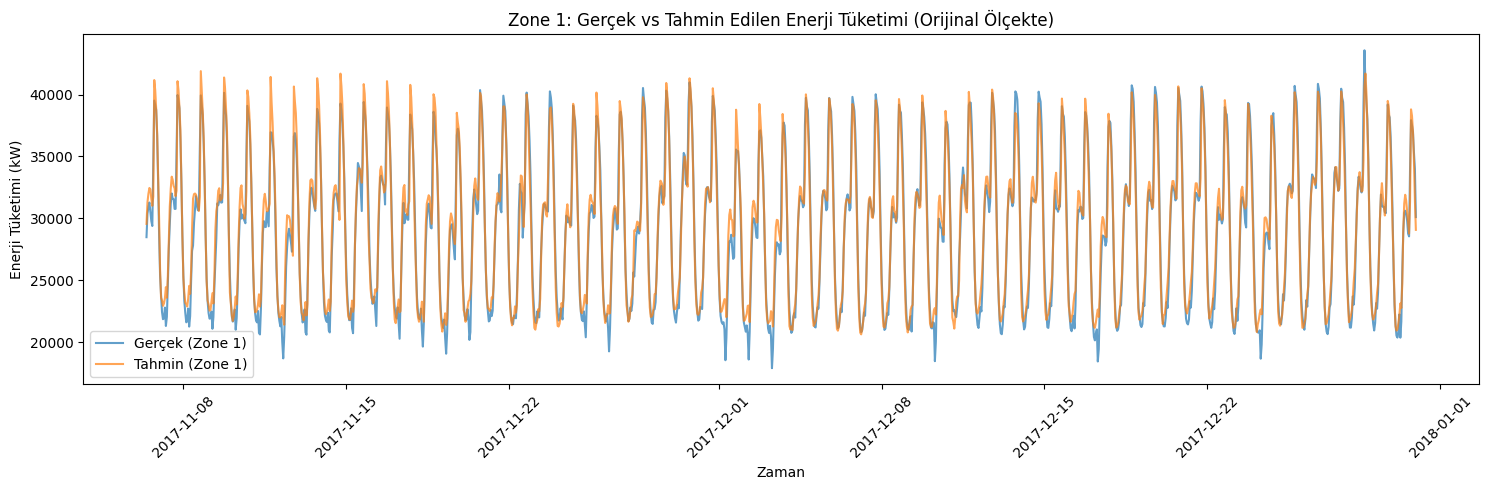

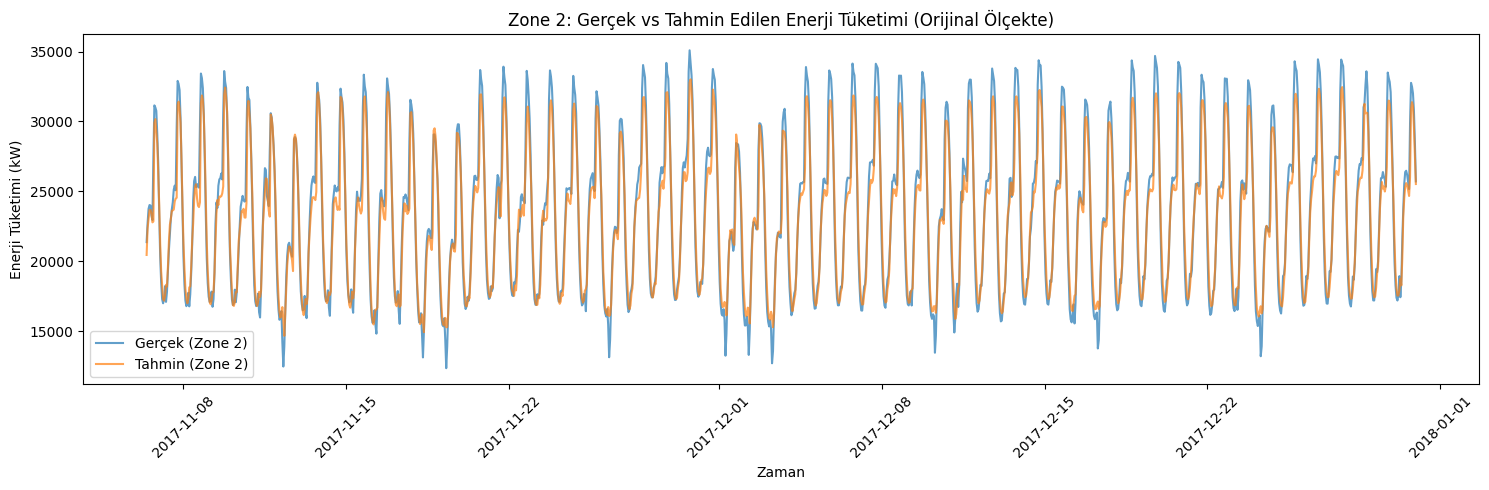

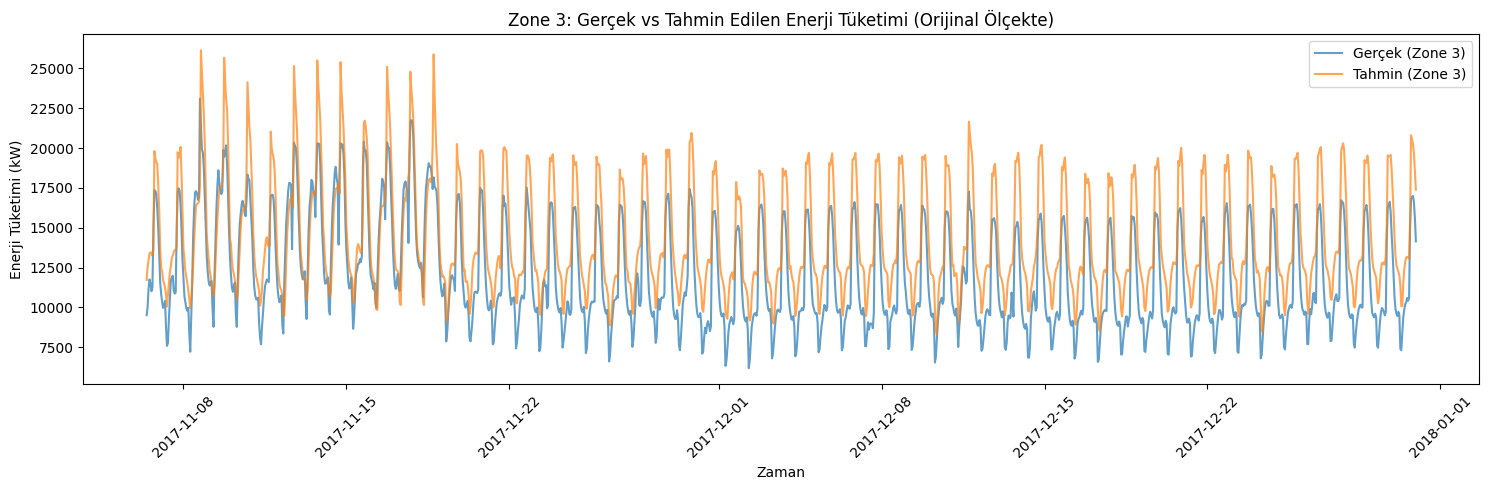

In [ ]:
# 5. Adım: Model Değerlendirme
# 5.1. Test seti üzerinde tahmin yapma
y_pred = model.predict(X_test)

# 5.2. Normalizasyonu geriye alma
dummy_array_test = np.zeros((y_test.shape[0], 8))
dummy_array_pred = np.zeros((y_pred.shape[0], 8))
dummy_array_test[:, -3:] = y_test
dummy_array_pred[:, -3:] = y_pred
y_test_original = scaler.inverse_transform(dummy_array_test)[:, -3:]
y_pred_original = scaler.inverse_transform(dummy_array_pred)[:, -3:]

# 5.3. Metrikleri hesaplama (R², MSE, MAE) - Orijinal ölçekte
zones = ['Zone 1', 'Zone 2', 'Zone 3']
for i in range(3):
    r2 = r2_score(y_test_original[:, i], y_pred_original[:, i])
    mse = mean_squared_error(y_test_original[:, i], y_pred_original[:, i])
    mae = mean_absolute_error(y_test_original[:, i], y_pred_original[:, i])
    print(f"\n{zones[i]} Metrikleri (Orijinal Ölçekte):")
    print(f"R² Skoru: {r2:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")

# 5.4. Gerçek ve tahmin edilen değerleri görselleştirme - Orijinal ölçekte
test_dates = df_hourly['Datetime'].iloc[-len(y_test):]
for i, zone in enumerate(zones):
    plt.figure(figsize=(15, 5))
    plt.plot(test_dates, y_test_original[:, i], label=f'Gerçek ({zone})', alpha=0.7)
    plt.plot(test_dates, y_pred_original[:, i], label=f'Tahmin ({zone})', alpha=0.7)
    plt.title(f'{zone}: Gerçek vs Tahmin Edilen Enerji Tüketimi (Orijinal Ölçekte)')
    plt.xlabel('Zaman')
    plt.ylabel('Enerji Tüketimi (kW)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

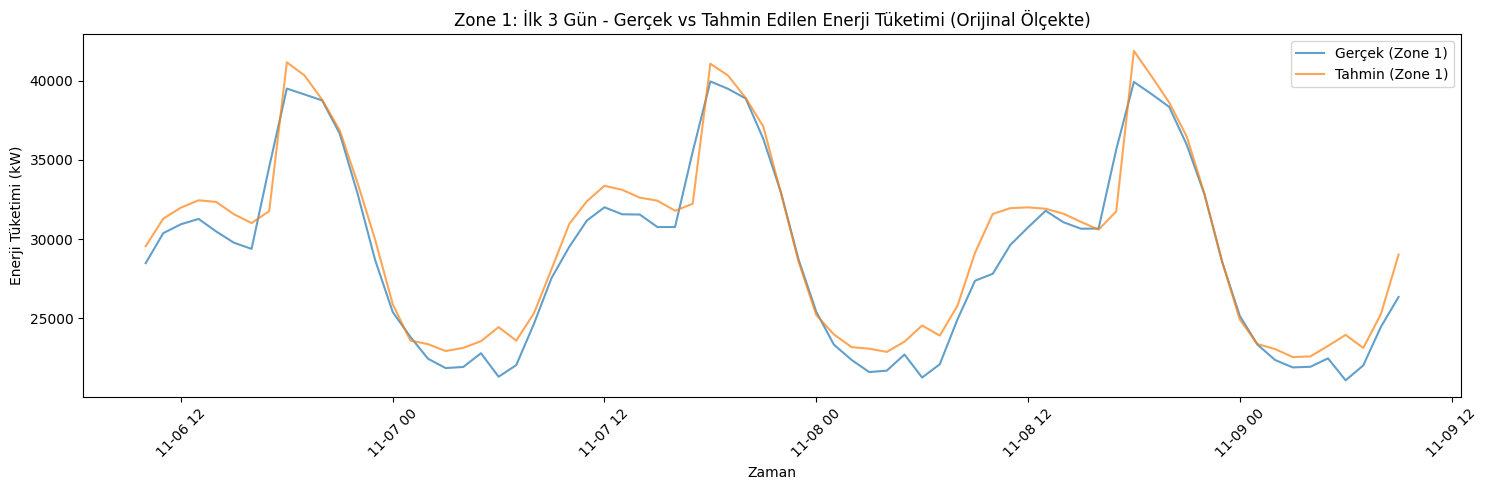

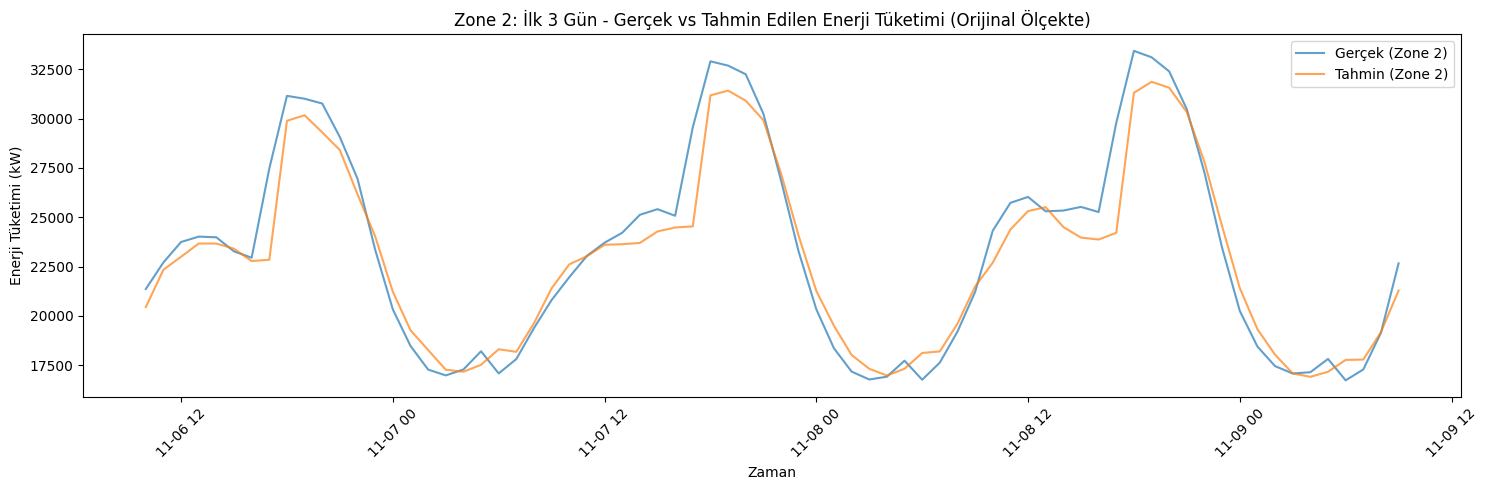

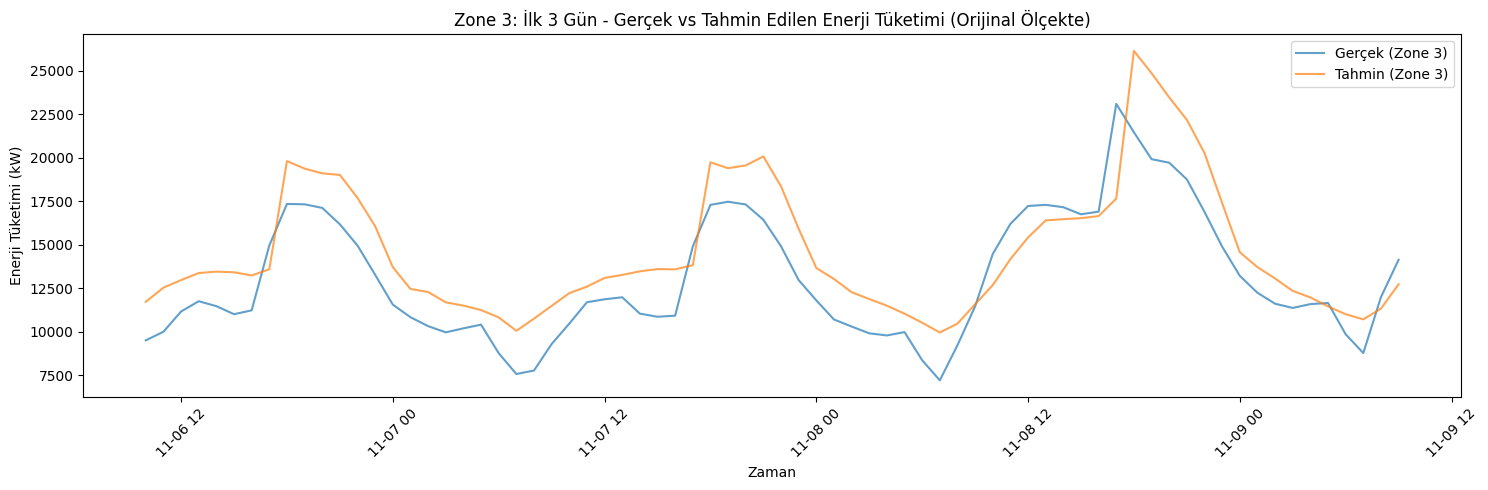

In [9]:
# 6. Adım: Test Setindeki İlk 3 Günün Tahminlerini Görselleştirme
# İlk 3 gün = 72 saat (saatlik veri olduğu için)
first_3_days = 72
test_dates_3days = test_dates[:first_3_days]
y_test_3days = y_test_original[:first_3_days]
y_pred_3days = y_pred_original[:first_3_days]

for i, zone in enumerate(zones):
    plt.figure(figsize=(15, 5))
    plt.plot(test_dates_3days, y_test_3days[:, i], label=f'Gerçek ({zone})', alpha=0.7)
    plt.plot(test_dates_3days, y_pred_3days[:, i], label=f'Tahmin ({zone})', alpha=0.7)
    plt.title(f'{zone}: İlk 3 Gün - Gerçek vs Tahmin Edilen Enerji Tüketimi (Orijinal Ölçekte)')
    plt.xlabel('Zaman')
    plt.ylabel('Enerji Tüketimi (kW)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

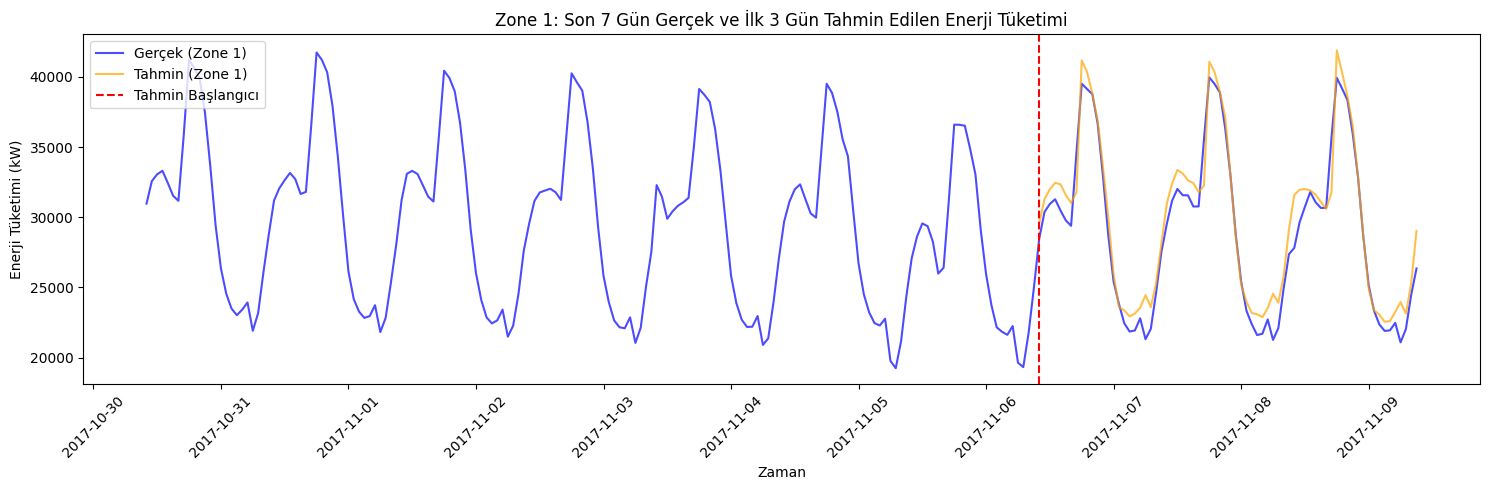

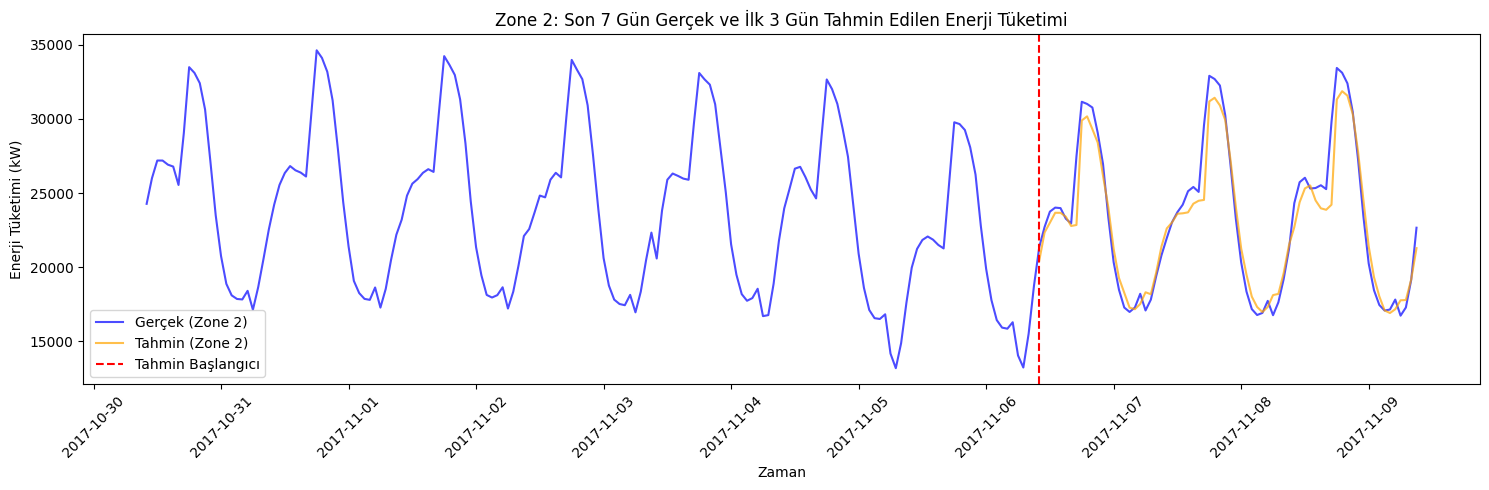

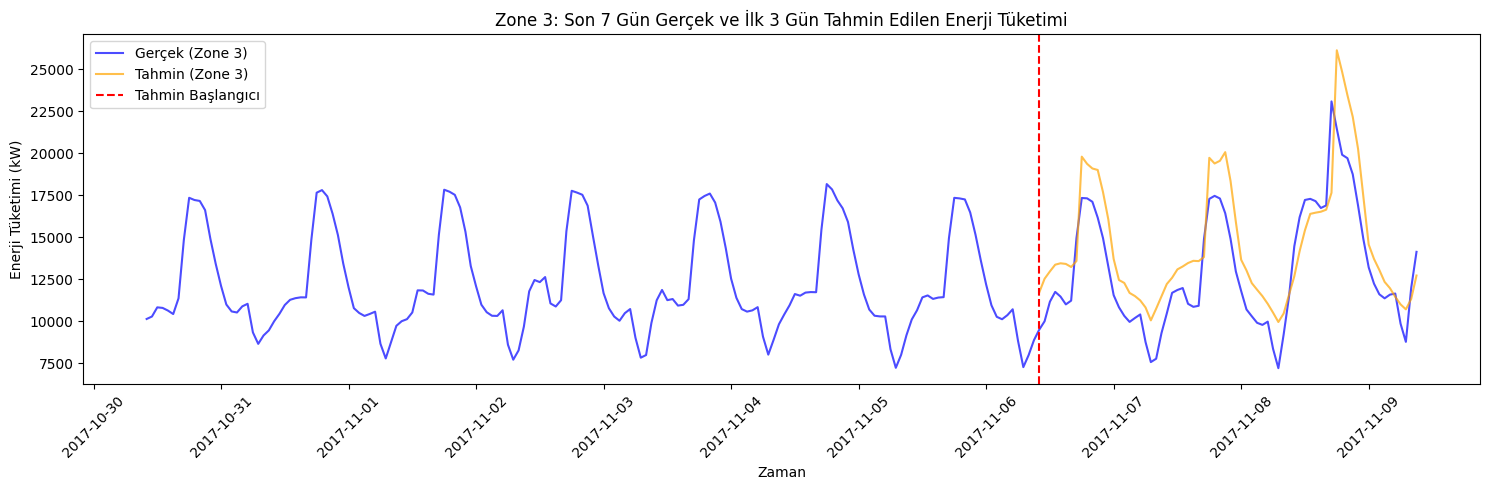

In [10]:
# 6. Adım: Test Setinden Önceki 7 Gün ve İlk 3 Gün Tahminlerini Görselleştirme
# Test setinden önceki 7 gün (168 saat) ve test setindeki ilk 3 gün (72 saat) = toplam 240 saat
last_7_days = 168  # Son 7 gün
first_3_days = 72  # İlk 3 gün
total_period = last_7_days + first_3_days

# Tarihleri ve verileri alalım
# Test setinden önceki 7 gün, df_hourly'den alınacak (test setinin başlangıcından önceki 168 saat)
# Test setindeki ilk 3 gün ise y_test_original ve y_pred_original'dan alınacak
start_idx = len(df_hourly) - len(y_test) - last_7_days  # Test setinden önceki 7 günün başlangıç indeksi
combined_dates = df_hourly['Datetime'].iloc[start_idx:start_idx + total_period]

# Gerçek değerler: Son 7 gün (df_hourly'den) + İlk 3 gün (y_test_original'dan)
last_7_days_data = df_hourly[features].iloc[start_idx:start_idx + last_7_days, -3:].values  # Son 3 sütun (Zone 1, 2, 3)
last_7_days_data_original = scaler.inverse_transform(np.pad(last_7_days_data, ((0, 0), (5, 0)), mode='constant'))[:, -3:]
combined_actual = np.vstack((last_7_days_data_original, y_test_original[:first_3_days]))

# Tahmin değerler: Son 7 gün için None (çizilmeyecek), ilk 3 gün için y_pred_original
combined_pred = np.full((total_period, 3), np.nan)  # İlk 168 saat NaN (tahmin yok)
combined_pred[-first_3_days:] = y_pred_original[:first_3_days]  # Son 72 saat tahmin

# Grafikleri çizelim
for i, zone in enumerate(zones):
    plt.figure(figsize=(15, 5))
    plt.plot(combined_dates, combined_actual[:, i], label=f'Gerçek ({zone})', alpha=0.7, color='blue')
    plt.plot(combined_dates, combined_pred[:, i], label=f'Tahmin ({zone})', alpha=0.7, color='orange')
    plt.axvline(x=combined_dates.iloc[last_7_days], color='red', linestyle='--', label='Tahmin Başlangıcı')
    plt.title(f'{zone}: Son 7 Gün Gerçek ve İlk 3 Gün Tahmin Edilen Enerji Tüketimi')
    plt.xlabel('Zaman')
    plt.ylabel('Enerji Tüketimi (kW)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()